In [670]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [671]:
evds=evdsAPI('dsIC3fiGlu')


In [672]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4629,31-10-2023,28.2552
4630,01-11-2023,28.2874
4631,02-11-2023,28.3315
4632,03-11-2023,28.3573


In [673]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [674]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


In [675]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [676]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


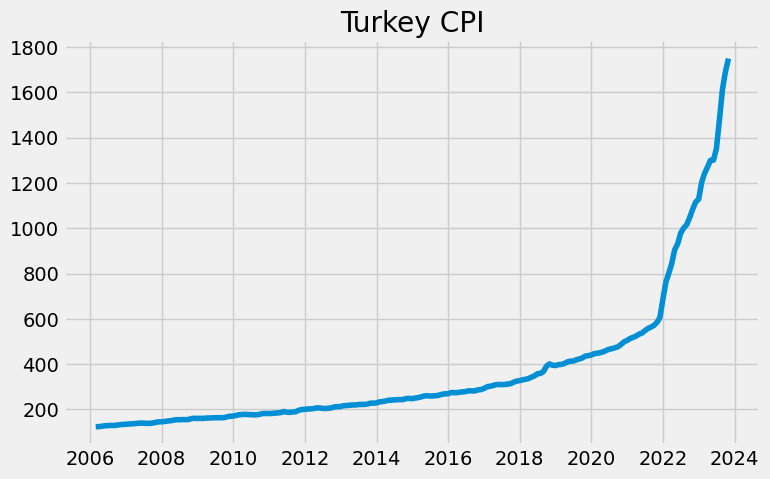

In [677]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [678]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [679]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del money["Tarih"]
money['Tarih'] = pd.to_datetime(money['YEARWEEK'] + '-1', format='%Y-%W-%w')
money = money.groupby(money['Tarih'].dt.to_period('M'))['TP_PR_ARZ13'].mean()
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
money

,Para Arzi
2006-02-28,2.424295
2006-03-31,2.473023
2006-04-30,2.514337
2006-05-31,2.648480
2006-06-30,2.794302
...,...
2023-06-30,104.034758
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258


In [680]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-06-30,111.098957
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411


In [681]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",end="2023-09-29",freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-04-30,10.0
2023-05-31,9.5
2023-06-30,9.6
2023-07-31,9.4


In [682]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4624,24-10-2023,88.00
4625,25-10-2023,90.14
4626,26-10-2023,88.45
4627,27-10-2023,90.73


In [683]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle

brent.iloc[-1,0]=90.44
brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [684]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')

df14["Brent"]=brent["TP_BRENTPETROL_EUBP"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

,Brent
TIME,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [685]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10


In [686]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
208,2023-6,95.646045
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870


In [687]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-06-30,95.646045
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870


In [688]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.5
1,2006-3,17.5
2,2006-4,17.5
3,2006-5,17.5
4,2006-6,17.5
...,...,...
209,2023-7,17.5
210,2023-8,23.5
211,2023-9,31.0
212,2023-10,33.0


In [689]:
dates=pd.date_range('2006-02-28','2023-12-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.5
2006-03-31,17.5
2006-04-30,17.5
2006-05-31,17.5
2006-06-30,17.5
...,...
2023-07-31,17.5
2023-08-31,23.5
2023-09-30,31.0


In [690]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-06-30,38.5600
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.3500


In [691]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:169,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:169,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-09-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-04-30,165.916139,169.886079,174.404111
2023-05-31,181.176925,179.726145,180.185729
2023-06-30,180.070938,186.141640,180.131292
2023-07-31,191.355951,193.831190,185.482059


In [692]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-11-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-06-30,22.100000
2023-07-31,29.480000
2023-08-31,37.370000
2023-09-30,39.180000


In [693]:
sanayi=evds.get_data(["TP.SANAYREV4.Y1"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
sanayi=sanayi.set_index(pd.date_range(start="2006-02-01",end="2023-09-01",freq="1M"))
del sanayi["Tarih"]
sanayi.columns=["Sanayi"]
sanayi

,Sanayi
2006-02-28,55.819129
2006-03-31,65.933232
2006-04-30,62.501869
2006-05-31,66.499838
2006-06-30,67.519860
...,...
2023-04-30,129.873251
2023-05-31,149.379361
2023-06-30,137.891848
2023-07-31,145.483816


In [694]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-11-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-06-30,39.5920
2023-07-31,33.1250
2023-08-31,29.4125
2023-09-30,41.6560


In [695]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-11-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-06-30,7.55
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30


In [696]:
borc=evds.get_data(["TP.KB.A09"],startdate="28-02-2010",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2010-02-28",end="2023-10-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2010-02-28,3.394344e+08
2010-03-31,3.406784e+08
2010-04-30,3.431629e+08
2010-05-31,3.405206e+08
2010-06-30,3.431419e+08
...,...
2023-05-31,2.348115e+09
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09


In [697]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-06-30,87.02
2023-07-31,81.68
2023-08-31,85.52
2023-09-30,89.55


In [698]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-06-30,51.56
2023-07-31,48.68
2023-08-31,52.39
2023-09-30,55.46


In [699]:
data=pd.DataFrame()
data["USDTL"]=df6["USD/TL"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Borç"]=borc["Borç"].shift(1)
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)
data

,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,REDK,REDKT,M3,TÜFE
Tarih,,,,,,,,,,,
2011-04-30,-0.810542,2.440539,-1.218711,-0.176965,-3.796845,0.684613,2.978727,1.593625,2.284537,1.642254,0.866270
2011-05-31,-0.399628,0.458932,-1.660706,1.110822,4.626047,0.570506,3.568114,-3.090570,-1.121135,0.477281,2.420827
2011-06-30,0.415548,1.955789,2.055258,2.490629,4.308985,0.194110,3.122424,-1.878794,-3.463549,2.450559,-1.430743
2011-07-31,2.804715,1.982717,2.237631,1.258223,-1.324582,0.019793,2.898935,-3.289474,-3.817214,2.189939,-0.409400
2011-08-31,3.747733,0.951638,1.664460,-0.296514,-3.655736,0.318355,3.279260,-4.213626,-5.533295,0.444077,0.726069
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,9.567224,33.393665,2.970482,5.505741,9.689321,5.675617,-6.136520,-5.585725,15.439600,9.488824
2023-08-31,10.505114,8.837304,26.763908,-4.670450,2.577506,2.618269,1.850455,4.701273,7.621200,5.968276,9.086793
2023-09-30,5.071342,5.195375,4.843457,0.000000,0.000000,4.384930,2.080815,4.712348,5.859897,4.845313,4.753114


In [700]:
data.iloc[-2,3:7]=[1.0060,2.001682,3.750938,2.154973]
data.iloc[-2,9:]=[3.373522,3.43]
data.iloc[-3,3:5]=[1.171409,-4.162503]
data


,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,REDK,REDKT,M3,TÜFE
Tarih,,,,,,,,,,,
2011-04-30,-0.810542,2.440539,-1.218711,-0.176965,-3.796845,0.684613,2.978727,1.593625,2.284537,1.642254,0.866270
2011-05-31,-0.399628,0.458932,-1.660706,1.110822,4.626047,0.570506,3.568114,-3.090570,-1.121135,0.477281,2.420827
2011-06-30,0.415548,1.955789,2.055258,2.490629,4.308985,0.194110,3.122424,-1.878794,-3.463549,2.450559,-1.430743
2011-07-31,2.804715,1.982717,2.237631,1.258223,-1.324582,0.019793,2.898935,-3.289474,-3.817214,2.189939,-0.409400
2011-08-31,3.747733,0.951638,1.664460,-0.296514,-3.655736,0.318355,3.279260,-4.213626,-5.533295,0.444077,0.726069
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,9.567224,33.393665,2.970482,5.505741,9.689321,5.675617,-6.136520,-5.585725,15.439600,9.488824
2023-08-31,10.505114,8.837304,26.763908,-4.670450,2.577506,2.618269,1.850455,4.701273,7.621200,5.968276,9.086793
2023-09-30,5.071342,5.195375,4.843457,1.171409,-4.162503,4.384930,2.080815,4.712348,5.859897,4.845313,4.753114


In [701]:
new_row=pd.DataFrame({"İşsizlik":[9.22,9.23]})
new_row=new_row.set_index(pd.date_range(start="2023-09-30",periods=2,freq="1M"))
issizlik=pd.concat([issizlik,new_row],axis=0)
issizlik

,İşsizlik
2014-01-31,9.20
2014-02-28,9.50
2014-03-31,9.50
2014-04-30,9.70
2014-05-31,9.70
...,...
2023-06-30,9.60
2023-07-31,9.40
2023-08-31,9.20
2023-09-30,9.22


In [702]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
data=data.dropna(axis=0)
data=data[['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','Şok','M3','İşsizlik','Politika Faizi',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.5140,11.01,-13.258747,0.82,1.817559,-0.584687,3.267877,9.0220,-3.691204,-5.094658,1,3.413428,9.20,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.4575,0.00,-4.776023,0.73,3.306415,0.808574,1.451593,10.6275,2.179150,0.919060,0,2.079333,9.50,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,15.8900,0.00,12.632839,0.80,0.500514,0.193691,0.341852,11.3125,0.471546,0.641623,1,0.229599,9.50,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.8625,0.00,-1.068156,0.73,1.106676,0.478162,0.129671,11.0200,4.682667,5.892031,1,0.730196,9.70,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.4280,0.00,1.476989,0.80,-0.699811,0.091080,0.468727,10.4940,1.283880,2.058652,0,-0.093468,9.70,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,7.066073,16.807611,-0.030212,38.5600,0.00,-7.690161,7.55,0.788974,2.406884,5.711697,39.5920,-7.925087,-11.057444,0,-1.142443,9.60,12.84,3.920498
2023-07-31,11.475241,33.393665,2.970482,45.8250,34.00,5.505741,7.70,9.567224,9.689321,5.675617,33.1250,-6.136520,-5.585725,1,15.439600,9.40,17.50,9.488824
2023-08-31,10.505114,26.763908,-4.670450,45.7650,0.00,2.577506,6.81,8.837304,2.618269,1.850455,29.4125,4.701273,7.621200,1,5.968276,9.20,23.50,9.086793


In [703]:
'''features=data.iloc[:,:-1].columns
X = data[features]
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
best_mse=float("inf")
best_features=[]
for r in range(3, 15):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        reg = linear_model.Lasso(alpha=0.1)
        reg.fit(X_train_subset,y_train)
        
        
        
        # Modeli kullanarak tahmin yapın
        y_pred = reg.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)'''

'features=data.iloc[:,:-1].columns\nX = data[features]\ny=data[["TÜFE"]]\nX_train=X.iloc[:-3,:]\nX_test=X.iloc[-3:,:]\ny_train=y.iloc[:-3,:]\ny_test=y.iloc[-3:,:]\nbest_mse=float("inf")\nbest_features=[]\nfor r in range(3, 15):\n    for combo in combinations(features, r):\n        selected_features = list(combo)\n        X_train_subset = X_train[selected_features]\n        X_test_subset = X_test[selected_features]\n        \n        # MLP Regressor modelini oluşturun ve eğitin\n        reg = linear_model.Lasso(alpha=0.1)\n        reg.fit(X_train_subset,y_train)\n        \n        \n        \n        # Modeli kullanarak tahmin yapın\n        y_pred = reg.predict(X_test_subset)\n        \n        # Ortalama kare hata (MSE) hesaplayın\n        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))\n        \n        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin\n        if rmse1 < best_mse:\n            best_mse = rmse1\n            best_features = selected_features\n\n# En iyi

In [704]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
model=LinearRegression()
model.fit(X_train,y_train)
rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [705]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [706]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'ParaArzi', 'Borç', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [707]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'ParaArzi', 'REDK', 'REDKT', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [708]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [709]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [710]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [711]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Linear Regression,0.075023
Lars Regression,0.106843
Kernel Regression,0.120861
Bayesian Regression,0.146481
Gaussian Regression,0.146498
SGD Regressor,0.208894
Lasso Regression,0.212767


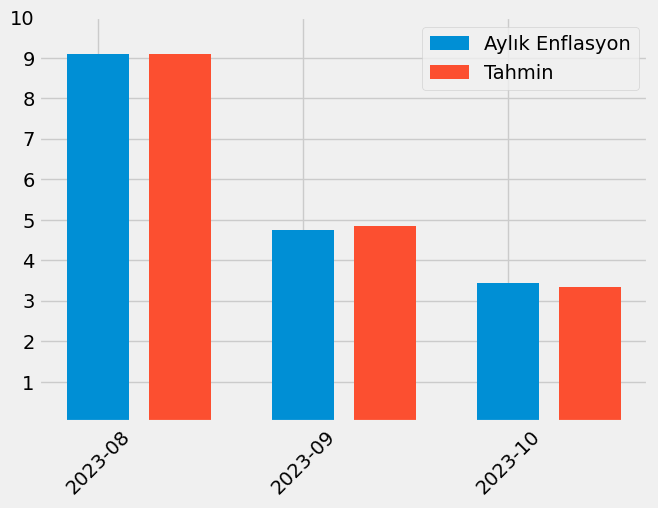

In [712]:
X_axis = np.arange(len(tahminler))
plt.figure(figsize=(7,5)) 
plt.bar(X_axis,tahminler["Aylık Enflasyon"],width=0.3,label="Aylık Enflasyon")
plt.bar(X_axis+0.4,tahminler["Linear Regression"],width=0.3,label="Tahmin")
plt.xticks(X_axis,tahminler.index.strftime("%Y-%m"),rotation=45)
plt.yticks(np.arange(1,11,1))
plt.legend()

In [713]:
from statsmodels.tsa.arima.model import ARIMA

model = SARIMAX(df6["USD/TL"].head(213), order=(0,2,1),seasonal_order=(0,0,0,12),trend='c')
model_fit = model.fit()
usdtahmin = model_fit.forecast(steps=26)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[208:,0]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.670384
2023-12-31,29.498688
2024-01-31,30.331025
2024-02-29,31.167397
2024-03-31,32.007802


In [714]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import month_plot
import warnings

df14.iloc[-1,0]=88.70
model = SARIMAX(df14["Brent"], order=(1, 1, 0))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
brenttahmin=pd.DataFrame(forecast_values)
brenttahmin.columns=["Brent"]
row=pd.DataFrame({"Brent":df14.iloc[209:213,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
brenttahmin=pd.concat([row,brenttahmin],axis=0)
brenttahmin

,Brent
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381
2023-10-31,88.700000
2023-11-30,87.000131
2023-12-31,86.424795
2024-01-31,86.230068
2024-02-29,86.164160
2024-03-31,86.141853
2024-04-30,86.134303


In [715]:
model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(1,1,1),seasonal_order=(0,1,1,12))
model_fit = model.fit()
perakendetahmin = model_fit.forecast(steps=28)
perakendetahmin=pd.DataFrame(perakendetahmin)
perakendetahmin.columns=["Perakende"]
row=pd.DataFrame({"Perakende":perakende1.iloc[163,0]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
perakendetahmin=pd.concat([row,perakendetahmin],axis=0)
perakendetahmin

,Perakende
2023-08-31,184.748497
2023-09-30,177.058336
2023-10-31,178.125306
2023-11-30,179.371911
2023-12-31,179.533206
2024-01-31,180.650546
2024-02-29,180.458038
2024-03-31,182.407175
2024-04-30,180.242428
2024-05-31,181.499598


In [716]:
model = SARIMAX(money["Para Arzi"], order=(0,2,2))
model_fit = model.fit()


# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
paraarzitahmin=pd.DataFrame(forecast_values)
paraarzitahmin.columns=["Para Arzi"]
paraarzitahmin=pd.concat([pd.DataFrame({"Para Arzi":money.iloc[209:,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M")),paraarzitahmin],axis=0)
paraarzitahmin

,Para Arzi
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258
2023-10-31,125.689935
2023-11-30,129.796312
2023-12-31,134.100833
2024-01-31,138.405354
2024-02-29,142.709875
2024-03-31,147.014397
2024-04-30,151.318918


In [717]:
model = SARIMAX(kfaiz["Kredi Faizi"], order=(1,1,0),seasonal_order=(0,0,0,12))
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kfaiztahmin=pd.DataFrame(forecast_values)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.350000
2023-10-31,59.392500
2023-11-30,60.868903
2023-12-31,61.585341
2024-01-31,61.933000
2024-02-29,62.101705
2024-03-31,62.183570
2024-04-30,62.223296
2024-05-31,62.242574


In [718]:
model = ARIMA(mfaiz, order=(3, 1, 1))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
mfaiztahmin=pd.DataFrame(forecast_values)
mfaiztahmin.columns=["Mevduat Faizi"]
new_row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
mfaiztahmin=pd.concat([new_row,mfaiztahmin],axis=0)
mfaiztahmin

,Mevduat Faizi
2023-08-31,29.412500
2023-09-30,41.656000
2023-10-31,43.892500
2023-11-30,36.284893
2023-12-31,40.437049
2024-01-31,46.223245
2024-02-29,41.069543
2024-03-31,39.490688
2024-04-30,44.928230
2024-05-31,43.911284


In [719]:
usdtahmin["brent"]=brenttahmin
usdtahmin=usdtahmin.dropna(axis=0)
degisim=pd.DataFrame((((usdtahmin["USDTL"]*usdtahmin["brent"]).pct_change(periods=1)+1).values)[1:],index=pd.date_range(start="2023-08-30",end="2026-01-30",freq="1M"))
degisim.columns=["Değişim"]
degisim=degisim.iloc[2:]
degisim

,Değişim
2023-10-31,0.976452
2023-11-30,1.009869
2023-12-31,1.022086
2024-01-31,1.025899
2024-02-29,1.026789
2024-03-31,1.026698
2024-04-30,1.026292
2024-05-31,1.025797
2024-06-30,1.025286
2024-07-31,1.024786


In [720]:
motorintahmin=pd.DataFrame()
motorintahmin["Değişim"]=degisim
motorintahmin["Motorin"]=38.9
for i in range(1,27):
    motorintahmin.iloc[i,1]=motorintahmin.iloc[i,0]*motorintahmin.iloc[i-1,1]

del motorintahmin["Değişim"]
new_row=pd.DataFrame({"Motorin":motorin.iloc[247,0]},index=pd.date_range(start="2023-11-30",end="2023-09-29",freq="1M"))
motorintahmin=pd.concat([new_row,motorintahmin],axis=0)
motorintahmin

,Motorin
2023-10-31,38.900000
2023-11-30,39.283919
2023-12-31,40.151562
2024-01-31,41.191462
2024-02-29,42.294956
2024-03-31,43.424163
2024-04-30,44.565885
2024-05-31,45.715530
2024-06-30,46.871497
2024-07-31,48.033232


In [721]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-01-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,35
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [722]:
model = ARIMA(df3["Kredi"], order=(5, 2, 0))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kreditahmin=pd.DataFrame(forecast_values)
kreditahmin.columns=["Kredi"]
new_row=pd.DataFrame({"Kredi":df3["Kredi"].iloc[209:]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
kreditahmin=pd.concat([new_row,kreditahmin],axis=0)
kreditahmin

,Kredi
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,106.225550
2023-12-31,110.790038
2024-01-31,114.099325
2024-02-29,115.878374
2024-03-31,119.374957
2024-04-30,122.213609


In [723]:
model = ARIMA(borc["Borç"], order=(0, 2, 1), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 27# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
borctahmin=pd.DataFrame(forecast_values)
borctahmin.columns=["Borç"]
new_row=pd.DataFrame({"Borç":[2643068440,2758965144,2859751220]},index=pd.date_range(start="2023-07-30",end="2023-10-29",freq="1M"))
borctahmin=pd.concat([new_row,borctahmin],axis=0)
borctahmin

,Borç
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.967250e+09
2023-11-30,3.074749e+09
2023-12-31,3.182249e+09
2024-01-31,3.289748e+09
2024-02-29,3.397247e+09
2024-03-31,3.504746e+09
2024-04-30,3.612245e+09


In [724]:
model = SARIMAX(redk["REDK"], order=(1, 1, 2),trend='c')

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 27# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redktahmin=pd.DataFrame(forecast_values)
redktahmin.columns=["REDK"]
new_row=pd.DataFrame({"REDK":[85.52,89.55,89.03]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
redktahmin=pd.concat([new_row,redktahmin],axis=0)
redktahmin

,REDK
2023-08-31,85.520000
2023-09-30,89.550000
2023-10-31,89.030000
2023-11-30,88.272991
2023-12-31,88.002239
2024-01-31,87.777102
2024-02-29,87.585270
2024-03-31,87.417756
2024-04-30,87.267999
2024-05-31,87.131207


In [725]:
model = SARIMAX(redkt["REDKT"], order=(1, 1, 2), seasonal_order=(1, 0, 0, 10),trend='c')

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 27# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redkttahmin=pd.DataFrame(forecast_values)
redkttahmin.columns=["REDKT"]
new_row=pd.DataFrame({"REDKT":[52.39,55.46,55.90]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
redkttahmin=pd.concat([new_row,redkttahmin],axis=0)
redkttahmin

,REDKT
2023-08-31,52.390000
2023-09-30,55.460000
2023-10-31,55.900000
2023-11-30,54.460918
2023-12-31,53.079366
2024-01-31,52.018375
2024-02-29,51.359168
2024-03-31,50.888966
2024-04-30,51.523293
2024-05-31,51.517532


In [726]:
model = SARIMAX(m3["M3 Para Arzi"], order=(1, 2, 2),trend='c')

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
m3tahmin=pd.DataFrame(forecast_values)
m3tahmin.columns=["M3 Para Arzi"]
new_row=pd.DataFrame({"M3 Para Arzi":m3["M3 Para Arzi"].iloc[209:]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
m3tahmin=pd.concat([new_row,m3tahmin],axis=0)
m3tahmin

,M3 Para Arzi
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933329
2023-11-30,135.271138
2023-12-31,140.348995
2024-01-31,144.846469
2024-02-29,149.873100
2024-03-31,154.496557
2024-04-30,159.500264


In [727]:
model = SARIMAX(issizlik["İşsizlik"], order=(2, 1, 2), seasonal_order=(1, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
issizliktahmin=pd.DataFrame(forecast_values)
issizliktahmin.columns=["İşsizlik"]
new_row=pd.DataFrame({"İşsizlik":[9.23]},index=pd.date_range(start="2023-10-30",end="2023-11-29",freq="1M"))
issizliktahmin=pd.concat([new_row,issizliktahmin],axis=0)
issizliktahmin

,İşsizlik
2023-10-31,9.230000
2023-11-30,9.149737
2023-12-31,9.174256
2024-01-31,9.339446
2024-02-29,9.172552
2024-03-31,9.193320
2024-04-30,9.271810
2024-05-31,9.320286
2024-06-30,9.264167
2024-07-31,9.379936


In [728]:
model = SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"], order=(0, 1, 0),seasonal_order=(0,0,1,12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
enfbelirsizliktahmin=pd.DataFrame(forecast_values)
enfbelirsizliktahmin.columns=["Enflasyon Belirsizliği"]
new_row=pd.DataFrame({"Enflasyon Belirsizliği":[6.81,7.3,5.57]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
enfbelirsizliktahmin=pd.concat([new_row,enfbelirsizliktahmin],axis=0)
enfbelirsizliktahmin

,Enflasyon Belirsizliği
2023-08-31,6.810000
2023-09-30,7.300000
2023-10-31,5.570000
2023-11-30,5.736679
2023-12-31,5.801851
2024-01-31,5.993937
2024-02-29,5.550952
2024-03-31,5.503268
2024-04-30,5.534476
2024-05-31,5.388792


In [729]:
model = SARIMAX(sanayi["Sanayi"], order=(3, 1, 2), seasonal_order=(1, 0, 4, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 28# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
sanayitahmin=pd.DataFrame(forecast_values)
sanayitahmin.columns=["Sanayi"]
new_row=pd.DataFrame({"Sanayi":[149.23]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
sanayitahmin=pd.concat([new_row,sanayitahmin],axis=0)
sanayitahmin

,Sanayi
2023-08-31,149.230000
2023-09-30,150.978094
2023-10-31,154.000195
2023-11-30,153.693821
2023-12-31,161.045096
2024-01-31,142.034040
2024-02-29,134.538117
2024-03-31,150.322179
2024-04-30,129.424585
2024-05-31,143.222749


In [730]:

model = SARIMAX(df6["USD/TL"].iloc[:-1], order=(0,2,1),seasonal_order=(0,0,0,12))
model_fit = model.fit()
usdtahmin = model_fit.forecast(steps=26)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[207:,0]},index=pd.date_range(start="2023-05-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-05-31,19.719514
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.674638
2023-12-31,29.503163
2024-01-31,30.331688
2024-02-29,31.160213


In [731]:
new_row=pd.DataFrame({"Motorin":39.18},index=pd.date_range(start="2023-09-30",periods=1,freq="1M"))
new_row=new_row.set_index(pd.date_range(start="2023-09-30",periods=1,freq="1M"))
motorintahmin=pd.concat([new_row,motorintahmin],axis=0)
motorintahmin

,Motorin
2023-09-30,39.180000
2023-10-31,38.900000
2023-11-30,39.283919
2023-12-31,40.151562
2024-01-31,41.191462
2024-02-29,42.294956
2024-03-31,43.424163
2024-04-30,44.565885
2024-05-31,45.715530
2024-06-30,46.871497


In [732]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin["USDTL"].rolling(3).mean(),paraarzitahmin["Para Arzi"].shift(1),motorintahmin["Motorin"],enfbelirsizliktahmin,perakendetahmin,sanayitahmin,kreditahmin.rolling(2).mean(),redktahmin,redkttahmin,m3tahmin.shift(1),borctahmin.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin



tahmindf["Şok"]=0

tahmindf=tahmindf[['USDTL', 'Motorin', 'Perakende', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDK','REDKT','Şok','M3 Para Arzi','İşsizlik']]

tahmindf.columns=data.columns[:16]
tahmindf=tahmindf.dropna(axis=0)
tahmindf.iloc[-27:-12]

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik
2023-10-31,1.709911,-0.714650,0.602610,59.392500,0.0,2.001682,5.570000,2.782256,3.653039,2.752662,43.892500,-0.580681,0.793365,0,2.613859,9.230000
2023-11-30,2.047434,0.986937,0.699847,60.868903,0.0,-0.198944,5.736679,2.666670,3.759038,1.756555,36.284893,-0.850286,-2.574387,0,3.373522,9.149737
2023-12-31,3.010070,2.208648,0.089922,61.585341,0.0,4.783065,5.801851,3.267069,3.622854,2.841703,40.437049,-0.306720,-2.536777,0,3.312991,9.174256
2024-01-31,2.889399,2.589937,0.622358,61.933000,35.0,-11.804803,5.993937,3.316366,3.496192,3.628207,46.223245,-0.255832,-1.998876,0,3.753836,9.339446
2024-02-29,2.808257,2.678939,-0.106563,62.101705,0.0,-5.277554,5.550952,3.209914,3.378087,2.262595,41.069543,-0.218545,-1.267258,0,3.204493,9.172552
2024-03-31,2.731548,2.669837,1.080105,62.183570,0.0,11.732037,5.503268,3.110083,3.267702,2.293976,39.490688,-0.191258,-0.915518,0,3.470317,9.193320
2024-04-30,2.658919,2.629233,-1.186766,62.223296,0.0,-13.901870,5.534476,3.016274,3.164302,2.692942,44.928230,-0.171312,1.246494,0,3.084914,9.271810
2024-05-31,2.590051,2.579651,0.697488,62.242574,0.0,10.661161,5.388792,2.927959,3.067245,1.905464,43.911284,-0.156749,-0.011181,0,3.238718,9.320286
2024-06-30,2.524661,2.528610,2.193445,62.251928,0.0,-1.377220,5.336616,2.844668,2.975965,2.116327,40.146185,-0.146130,-2.431088,0,2.962789,9.264167
2024-07-31,2.462492,2.478554,0.770242,62.256468,0.0,8.002658,5.384569,2.765985,2.889960,2.646045,42.923391,-0.138400,-2.201248,0,3.045054,9.379936


In [733]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'ParaArzi', 'REDK', 'REDKT', 'İşsizlik']
X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1691.04
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-10-30", end="2026-01-27", freq="1M"))
tüfetahmin1

,SGD Regressor
2023-10-31,1747.479247
2023-11-30,1806.779251
2023-12-31,1874.460704
2024-01-31,1946.573631
2024-02-29,2021.470121
2024-03-31,2097.560130
2024-04-30,2181.641467
2024-05-31,2263.518925
2024-06-30,2341.994746
2024-07-31,2424.816739


In [734]:
from itertools import chain, combinations
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
features=tahmindf.columns
# Bütün kombinasyonları döndüren bir fonksiyon
def all_subsets(features):
    return chain(*map(lambda x: combinations(features, x), range(0, len(features)+1)))

# Başlangıçta fark olarak büyük bir değer atayarak en yakın değeri bulmaya çalışıyoruz
min_difference = float('inf')
min_difference1 = float('inf')
best_features = None

for subset in all_subsets(features):
    if not subset:  # boş kombinasyonları atla
        continue

    # Kullanılacak olan özellikleri seç
    X_subset = data[list(subset)]

    # Modeli eğit
    
    model = linear_model.Lars(fit_intercept=True)
    model.fit(X_subset,y)

    # Tahmin yap
    lassotahmin = model.predict(np.array(tahmindf[list(subset)]))
    result = 1614.31
    results = []
    for i in range(len(lassotahmin)):
        result *= (1 + lassotahmin[i] / 100)
        results.append(result)

    # Şartları kontrol et
    difference_1 = abs(results[0] - 1691)
    difference_2 = abs(results[1] - 1758)
    difference_3=abs(results[3]-1896)
    
    if difference_3<min_difference1 and (difference_1 + difference_2) < min_difference:
        min_difference = difference_1 + difference_2
        min_difference1=abs(results[3]-1896)
        best_features = subset

print("En iyi feature kombinasyonu:", best_features)


En iyi feature kombinasyonu: ('Kredi Faizi', 'Enflasyon Belirsizliği', 'Mevduat Faizi', 'REDK', 'REDKT', 'Şok')


In [735]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT']



X = data[features]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1691.04
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-10-30", end="2026-01-27", freq="1M"))
tüfetahmin2


,Linear Regression
2023-10-31,1747.981947
2023-11-30,1810.405938
2023-12-31,1878.142855
2024-01-31,1947.110627
2024-02-29,2022.936108
2024-03-31,2101.636124
2024-04-30,2187.117641
2024-05-31,2269.566550
2024-06-30,2348.421757
2024-07-31,2429.759093


In [736]:
features=['USDTL', 'Motorin', 'Kredi Faizi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'M3']


X = data[features]
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)


tüfetahmin5 = []
result = 1691.04
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-10-30", end="2026-01-27", freq="1M"))
tüfetahmin5

,Lasso Regression
2023-10-31,1743.596760
2023-11-30,1804.448244
2023-12-31,1873.724968
2024-01-31,1947.906785
2024-02-29,2022.246438
2024-03-31,2099.515406
2024-04-30,2178.453823
2024-05-31,2259.737757
2024-06-30,2342.647386
2024-07-31,2428.513662


In [737]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Mevduat Faizi', 'REDK', 'REDKT']

X = data[features]
reg = linear_model.Lars(fit_intercept=True)
reg.fit(X,y)



tüfetahmin6 = []
result = 1691.04
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-10-30", end="2026-01-27", freq="1M"))
tüfetahmin6


,Lars Regression
2023-10-31,1748.317703
2023-11-30,1812.490207
2023-12-31,1881.674555
2024-01-31,1951.256987
2024-02-29,2028.298880
2024-03-31,2108.125688
2024-04-30,2194.063076
2024-05-31,2276.987951
2024-06-30,2356.970877
2024-07-31,2439.278188


In [738]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT']

X = data[features]
krr = KernelRidge()
krr.fit(X, y)


tüfe = 1691.04  # İlk değeri 1691 ile başlatıyoruz

krrtahmin=krr.predict(tahmindf[features])
result = 1691.04
tüfetahmin7 = []
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2023-10-30", end="2026-01-27", freq="1M"))
tüfetahmin7

,Kernel Regression
2023-10-31,1746.418214
2023-11-30,1805.142075
2023-12-31,1872.283284
2024-01-31,1942.799610
2024-02-29,2018.408739
2024-03-31,2096.037031
2024-04-30,2180.768822
2024-05-31,2264.139368
2024-06-30,2344.617535
2024-07-31,2428.582967


In [739]:

features=['Motorin', 'Perakende Satış', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT']

X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1691.04  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-10-30",end="2026-01-27",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-10-31,1746.771349
2023-11-30,1796.402359
2023-12-31,1858.643823
2024-01-31,1930.757601
2024-02-29,2001.063184
2024-03-31,2070.733567
2024-04-30,2153.797628
2024-05-31,2234.330961
2024-06-30,2306.905166
2024-07-31,2386.632336


In [740]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik']
X = data[features]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1691.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-10-30",end="2026-01-27",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-10-31,1749.347325
2023-11-30,1814.250229
2023-12-31,1886.335759
2024-01-31,1960.969908
2024-02-29,2040.844489
2024-03-31,2123.075732
2024-04-30,2211.258575
2024-05-31,2298.138133
2024-06-30,2383.920857
2024-07-31,2473.167601


In [741]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,Ortalama
2023-10-31,1747.479247,1747.981947,1743.596760,1748.317703,1746.418214,1746.771349,1749.347325,1747.130364
2023-11-30,1806.779251,1810.405938,1804.448244,1812.490207,1805.142075,1796.402359,1814.250229,1807.131186
2023-12-31,1874.460704,1878.142855,1873.724968,1881.674555,1872.283284,1858.643823,1886.335759,1875.037992
2024-01-31,1946.573631,1947.110627,1947.906785,1951.256987,1942.799610,1930.757601,1960.969908,1946.767878
2024-02-29,2021.470121,2022.936108,2022.246438,2028.298880,2018.408739,2001.063184,2040.844489,2022.181137
2024-03-31,2097.560130,2101.636124,2099.515406,2108.125688,2096.037031,2070.733567,2123.075732,2099.526240
2024-04-30,2181.641467,2187.117641,2178.453823,2194.063076,2180.768822,2153.797628,2211.258575,2183.871576
2024-05-31,2263.518925,2269.566550,2259.737757,2276.987951,2264.139368,2234.330961,2298.138133,2266.631378
2024-06-30,2341.994746,2348.421757,2342.647386,2356.970877,2344.617535,2306.905166,2383.920857,2346.496903
2024-07-31,2424.816739,2429.759093,2428.513662,2439.278188,2428.582967,2386.632336,2473.167601,2430.107226


In [742]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[1:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[1:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[1:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[1:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

'''dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]'''





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








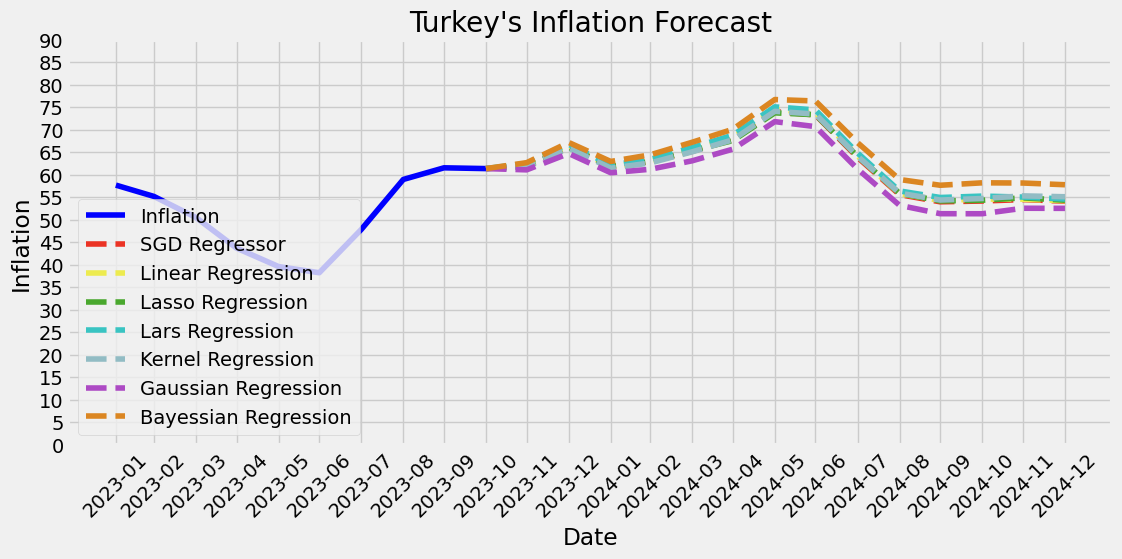

In [743]:








# Grafik çizdirelim
plt.figure(figsize=(12, 5))
plt.plot(df.iloc[191:201,1], label='Inflation', color='blue')
plt.plot(dfas.iloc[200:215,0],'--',label=dfas.columns[0], color='#EB3324')
plt.plot(dfas.iloc[200:215,1],'--',label=dfas.columns[1], color='#EDEB4F')
plt.plot(dfas.iloc[200:215,2],'--',label=dfas.columns[2], color='#4AA82E')
plt.plot(dfas.iloc[200:215,3],'--',label=dfas.columns[3], color='#39C4C2')
plt.plot(dfas.iloc[200:215,4],'--',label=dfas.columns[4],color='#92BCC4')
plt.plot(dfas.iloc[200:215,5],'--',label=dfas.columns[5],color='#AD4AC4')
plt.plot(dfas.iloc[200:215,6],'--',label=dfas.columns[6],color='#DB8622')
#plt.plot(dfas.iloc[199:,7],'--',label=dfas.columns[7])
#plt.plot(dfas.iloc[199:,8],'--',label=dfas.columns[8])
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dfas.iloc[191:215].index, dfas.iloc[191:215].index.strftime('%Y-%m'), rotation=45)
y_max = 100
y_min = 10
y_interval = 0.5
y_ticks = [0]
while y_ticks[-1] < 90:
    y_ticks.append(y_ticks[-1] + 5)









# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation Forecast")
plt.legend(loc=3)
plt.grid(True)
plt.show()


In [744]:
ekim_tahmin=((tüfetahmin.iloc[0,:-1]/1691)-1)*100
np.abs(ekim_tahmin-3.43).sort_values()

Bayessian Regression    0.020463
Lars Regression         0.040426
Linear Regression       0.060281
SGD Regressor           0.090009
Gaussian Regression     0.131872
Kernel Regression       0.152755
Lasso Regression        0.319606
Name: 2023-10-31 00:00:00, dtype: float64

In [745]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
row=pd.DataFrame({ekim_tahmin.index[0]:ekim_tahmin[0],ekim_tahmin.index[1]:ekim_tahmin[1],ekim_tahmin.index[2]:ekim_tahmin[2],ekim_tahmin.index[3]:ekim_tahmin[3],ekim_tahmin.index[4]:ekim_tahmin[4],ekim_tahmin.index[5]:ekim_tahmin[5],ekim_tahmin.index[6]:ekim_tahmin[6]},index=pd.date_range(start="2023-10-30",end="2023-11-29",freq="1M"))
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin["Ortalama"]=aylıktahmin.mean(axis=1)
aylıktahmin["Medyan"]=aylıktahmin.median(axis=1)
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,Ortalama,Medyan
2023-10-31,3.339991,3.369719,3.110394,3.389574,3.277245,3.298128,3.450463,3.319359,3.329675
2023-11-30,3.393460,3.571203,3.489998,3.670529,3.362531,2.841300,3.710121,3.434174,3.462086
2023-12-31,3.745972,3.741532,3.839219,3.817088,3.719442,3.464784,3.973296,3.757381,3.751677
2024-01-31,3.847129,3.672126,3.959056,3.697899,3.766328,3.879914,3.956568,3.825567,3.836348
2024-02-29,3.847606,3.894256,3.816387,3.948321,3.891762,3.641347,4.073218,3.873333,3.882547
2024-03-31,3.764093,3.890386,3.820947,3.935653,3.846014,3.481668,4.029275,3.824109,3.835062
2024-04-30,4.008530,4.067380,3.759840,4.076483,4.042476,4.011335,4.153542,4.017117,4.029796
2024-05-31,3.753021,3.769752,3.731267,3.779512,3.822989,3.739132,3.928964,3.789278,3.774632
2024-06-30,3.466983,3.474461,3.668993,3.512664,3.554471,3.248140,3.732705,3.522744,3.517704
2024-07-31,3.536387,3.463489,3.665352,3.492080,3.581200,3.456023,3.743696,3.562678,3.549532


In [746]:
yıllıktahmin=pd.DataFrame(dfas)
yıllıktahmin["Ortalama"]=yıllıktahmin.mean(axis=1)
yıllıktahmin["Medyan"]=yıllıktahmin.median(axis=1)
yıllıktahmin.iloc[-27:-12,:]


,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,Ortalama,Medyan
2023-10-31,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011
2023-11-30,62.005205,62.330393,61.796195,62.517279,61.858407,61.074759,62.675092,62.036762,62.020983
2023-12-31,66.109327,66.435629,66.044128,66.748598,65.916371,64.707681,67.161661,66.160485,66.134906
2024-01-31,61.745408,61.790028,61.856182,62.134559,61.431815,60.431216,62.941628,61.761548,61.775788
2024-02-29,62.847117,62.965215,62.909656,63.397234,62.600496,61.203160,64.407892,62.904396,62.907026
2024-03-31,65.194734,65.515741,65.348723,66.026831,65.074781,63.081990,67.204232,65.349576,65.349149
2024-04-30,67.813411,68.234642,67.568215,68.768890,67.746286,65.671643,70.091580,67.984952,67.899182
2024-05-31,74.036516,74.501503,73.745791,75.072117,74.084220,71.792324,76.698303,74.275825,74.180023
2024-06-30,73.277010,73.752525,73.325297,74.385049,73.471063,70.680840,76.378995,73.610111,73.540587
2024-07-31,63.856683,64.190662,64.106502,64.833914,64.111185,61.276377,67.123986,64.214187,64.150924


In [747]:
max_values = []
for index, row in yıllıktahmin.iterrows():
    max_value = row.max()  # Her satırın maksimum değerini bulur
    max_values.append(max_value)

# Sonuçları bir Series olarak oluşturur
max_values_series = pd.Series(max_values, index=yıllıktahmin.index)

# Her satırın maksimum değerlerini içeren
max_values_series.tail(26)

2023-11-30    62.675092
2023-12-31    67.161661
2024-01-31    62.941628
2024-02-29    64.407892
2024-03-31    67.204232
2024-04-30    70.091580
2024-05-31    76.698303
2024-06-30    76.378995
2024-07-31    67.123986
2024-08-31    58.931594
2024-09-30    57.652846
2024-10-31    58.194360
2024-11-30    58.149688
2024-12-31    57.770895
2025-01-31    57.385340
2025-02-28    56.746406
2025-03-31    56.069316
2025-04-30    55.467750
2025-05-31    55.004539
2025-06-30    54.636134
2025-07-31    54.358007
2025-08-31    54.110525
2025-09-30    53.591733
2025-10-31    53.200468
2025-11-30    52.941472
2025-12-31    52.657453
Freq: M, dtype: float64

In [748]:
min_values = []
for index, row in yıllıktahmin.iterrows():
    min_value = row.min()  # Her satırın maksimum değerini bulur
    min_values.append(min_value)

# Sonuçları bir Series olarak oluşturur
min_values_series = pd.Series(min_values, index=yıllıktahmin.index)

# Her satırın maksimum değerlerini içeren
min_values_series.tail(26)


2023-11-30    61.074759
2023-12-31    64.707681
2024-01-31    60.431216
2024-02-29    61.203160
2024-03-31    63.081990
2024-04-30    65.671643
2024-05-31    71.792324
2024-06-30    70.680840
2024-07-31    61.276377
2024-08-31    53.193780
2024-09-30    51.333107
2024-10-31    51.323879
2024-11-30    52.544250
2024-12-31    52.521021
2025-01-31    51.680703
2025-02-28    51.303090
2025-03-31    51.106356
2025-04-30    50.172076
2025-05-31    49.514031
2025-06-30    49.509911
2025-07-31    49.176750
2025-08-31    48.569800
2025-09-30    48.244642
2025-10-31    47.934179
2025-11-30    47.381333
2025-12-31    47.003378
Freq: M, dtype: float64

In [749]:
yıllıktahmin["Maksimum"]=max_values_series
yıllıktahmin["Minimum"]=min_values_series
yıllıktahmin.iloc[-27:-12]

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,Ortalama,Medyan,Maksimum,Minimum
2023-10-31,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011
2023-11-30,62.005205,62.330393,61.796195,62.517279,61.858407,61.074759,62.675092,62.036762,62.020983,62.675092,61.074759
2023-12-31,66.109327,66.435629,66.044128,66.748598,65.916371,64.707681,67.161661,66.160485,66.134906,67.161661,64.707681
2024-01-31,61.745408,61.790028,61.856182,62.134559,61.431815,60.431216,62.941628,61.761548,61.775788,62.941628,60.431216
2024-02-29,62.847117,62.965215,62.909656,63.397234,62.600496,61.203160,64.407892,62.904396,62.907026,64.407892,61.203160
2024-03-31,65.194734,65.515741,65.348723,66.026831,65.074781,63.081990,67.204232,65.349576,65.349149,67.204232,63.081990
2024-04-30,67.813411,68.234642,67.568215,68.768890,67.746286,65.671643,70.091580,67.984952,67.899182,70.091580,65.671643
2024-05-31,74.036516,74.501503,73.745791,75.072117,74.084220,71.792324,76.698303,74.275825,74.180023,76.698303,71.792324
2024-06-30,73.277010,73.752525,73.325297,74.385049,73.471063,70.680840,76.378995,73.610111,73.540587,76.378995,70.680840
2024-07-31,63.856683,64.190662,64.106502,64.833914,64.111185,61.276377,67.123986,64.214187,64.150924,67.123986,61.276377


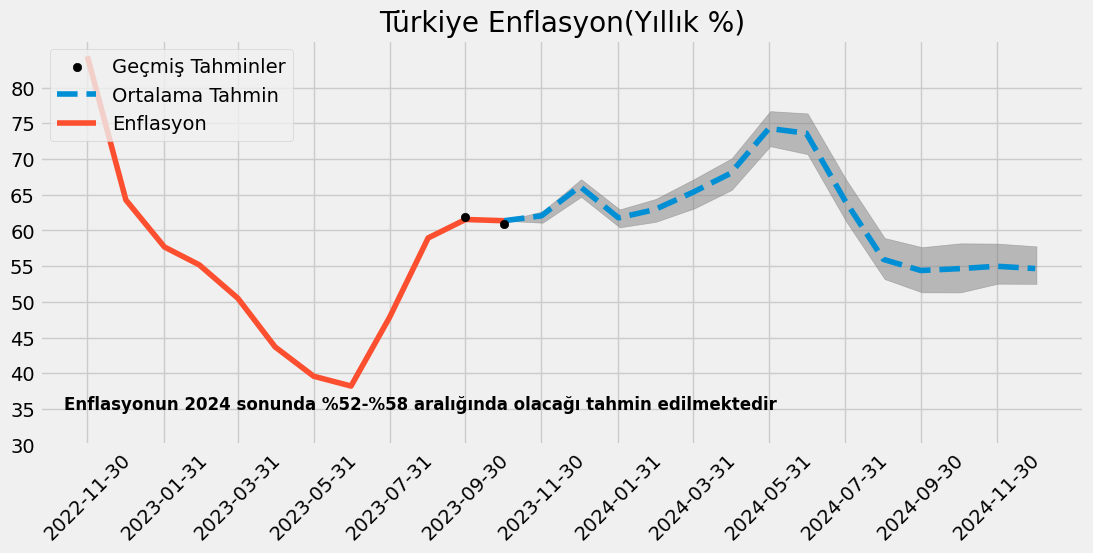

In [750]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.scatter(x=yıllıktahmin.index[199:201],y=[61.94,60.84],color='black',zorder=3,label='Geçmiş Tahminler')
plt.plot(yıllıktahmin["Ortalama"].iloc[200:215],'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[189:201],label="Enflasyon")
plt.fill_between(yıllıktahmin.iloc[200:216].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[200:216].shift(1), yıllıktahmin["Minimum"].iloc[200:216].shift(1), alpha=0.5, color='gray')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2024-06')

plt.text(annotation_date, 35, 'Enflasyonun 2024 sonunda %52-%58 aralığında olacağı tahmin edilmektedir', fontsize=12, color='black', horizontalalignment='right',fontweight='bold')

plt.xticks(yıllıktahmin.index[189:215][::2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend(loc=2)
plt.show()


([<matplotlib.axis.XTick at 0x22fe4acf370>,
 [Text(20027.0, 0, '2024-10-31'),
  Text(20088.0, 0, '2024-12-31'),
  Text(20147.0, 0, '2025-02-28'),
  Text(20208.0, 0, '2025-04-30'),
  Text(20269.0, 0, '2025-06-30'),
  Text(20331.0, 0, '2025-08-31'),
  Text(20392.0, 0, '2025-10-31'),
  Text(20453.0, 0, '2025-12-31')])

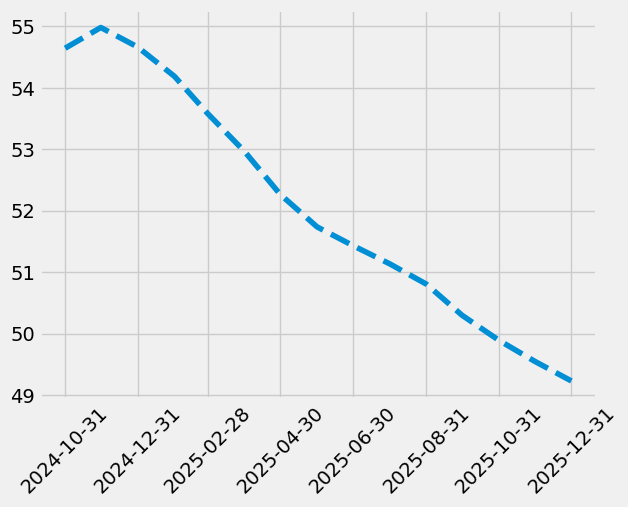

In [751]:
plt.plot(yıllıktahmin["Ortalama"].tail(15),'--',label="Ortalama Tahmin")
plt.xticks(yıllıktahmin.index[-15:][::2],rotation=45)

In [752]:
max_values_series.tail(15)

2024-10-31    58.194360
2024-11-30    58.149688
2024-12-31    57.770895
2025-01-31    57.385340
2025-02-28    56.746406
2025-03-31    56.069316
2025-04-30    55.467750
2025-05-31    55.004539
2025-06-30    54.636134
2025-07-31    54.358007
2025-08-31    54.110525
2025-09-30    53.591733
2025-10-31    53.200468
2025-11-30    52.941472
2025-12-31    52.657453
Freq: M, dtype: float64

In [753]:
yıllıktahmin["Ortalama"].tail(15)

2024-10-31    54.646248
2024-11-30    54.983701
2024-12-31    54.665849
2025-01-31    54.188164
2025-02-28    53.581426
2025-03-31    52.964453
2025-04-30    52.266118
2025-05-31    51.737286
2025-06-30    51.434649
2025-07-31    51.137187
2025-08-31    50.805071
2025-09-30    50.298702
2025-10-31    49.891163
2025-11-30    49.550457
2025-12-31    49.228873
Freq: M, Name: Ortalama, dtype: float64